<a href="https://colab.research.google.com/github/kishanshah98/londontimeseries/blob/main/London_Weather_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Seasonal Time Series - London Weather

### Introduction

This project focuses on seasonal time series analysis using the London Weather dataset, specifically examining historical temperature trends. Weather data was chosen because it provides a rich source of information for analyzing seasonal and long-term patterns that directly impact various aspects of daily life, such as agriculture, infrastructure, and public health. London, with its well-documented and consistent weather records, offers an ideal case for such an analysis.

To model and forecast future temperatures, we employed the SARIMA (Seasonal AutoRegressive Integrated Moving Average) approach, guided by the Box-Jenkins methodology. This systematic framework enabled us to identify an optimal model by thoroughly examining seasonality, trends, and residuals within the data. Our aim was to generate both short-term and long-term forecasts, providing valuable insights into London's evolving temperature patterns and potential future changes.

Dataset: https://www.kaggle.com/datasets/emmanuelfwerr/london-weather-data

### Installing and loading packages needed

In [ ]:
install.packages(c("readr", "dplyr", "lubridate", "ggplot2", "TSA", "forecast", "googledrive"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘leaps’, ‘locfit’, ‘tseries’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘urca’, ‘zoo’, ‘RcppArmadillo’




In [ ]:
# Load libraries
library(googledrive)
library(readr)
library(dplyr)
library(lubridate)
library(ggplot2)
library(forecast)
library(tseries)
library(TSA)

### Load the London Weather Dataset and Data Preprocessing

In [ ]:
drive_auth()
drive_download("london_weather.csv", path = "london_weather.csv", overwrite = TRUE)

# Read the downloaded CSV file
df <- read.csv("london_weather.csv")

# Convert the date column to character type first
df$date <- as.character(df$date)

# Now convert it to Date format (YYYYMMDD to Date)
df$date <- as.Date(df$date, format = "%Y%m%d")

# Check the first few rows again
print(head(df))

The googledrive package is requesting access to your Google account.
Enter '1' to start a new auth process or select a pre-authorized account.
1: Send me to the browser for a new auth process.
2: kishan725@gmail.com


Selection: 2


File downloaded:

• london_weather.csv <id: 1NE4xd3es72Z11eVAzRAXtuo168ETDZBm>

Saved locally as:

• london_weather.csv



        date cloud_cover sunshine global_radiation max_temp mean_temp min_temp
1 1979-01-01           2      7.0               52      2.3      -4.1     -7.5
2 1979-01-02           6      1.7               27      1.6      -2.6     -7.5
3 1979-01-03           5      0.0               13      1.3      -2.8     -7.2
4 1979-01-04           8      0.0               13     -0.3      -2.6     -6.5
5 1979-01-05           6      2.0               29      5.6      -0.8     -1.4
6 1979-01-06           5      3.8               39      8.3      -0.5     -6.6
  precipitation pressure snow_depth
1           0.4   101900          9
2           0.0   102530          8
3           0.0   102050          4
4           0.0   100840          2
5           0.0   102250          1
6           0.7   102780          1


In [ ]:
# Filter data from 2015 onwards, and ensure no missing max_temp
df_cleaned <- df %>%
  filter(date >= as.Date("2015-01-01") & !is.na(mean_temp))

In [ ]:
# Daily dataset (already cleaned)
daily_data <- df_cleaned %>%
  dplyr::select(date, mean_temp)

# Aggregate data by year and month, calculating the mean temperature
df_cleaned$month <- format(df_cleaned$date, "%Y-%m")  # Create a "year-month" column
monthly_data <- df_cleaned %>%
  group_by(month) %>%
  summarise(monthly_mean_temp = mean(mean_temp, na.rm = TRUE))

# Convert the "month" column to Date format for monthly data
monthly_data$date <- as.Date(paste0(monthly_data$month, "-01"))

### Creating Time Series and Plotting ACF, PACF

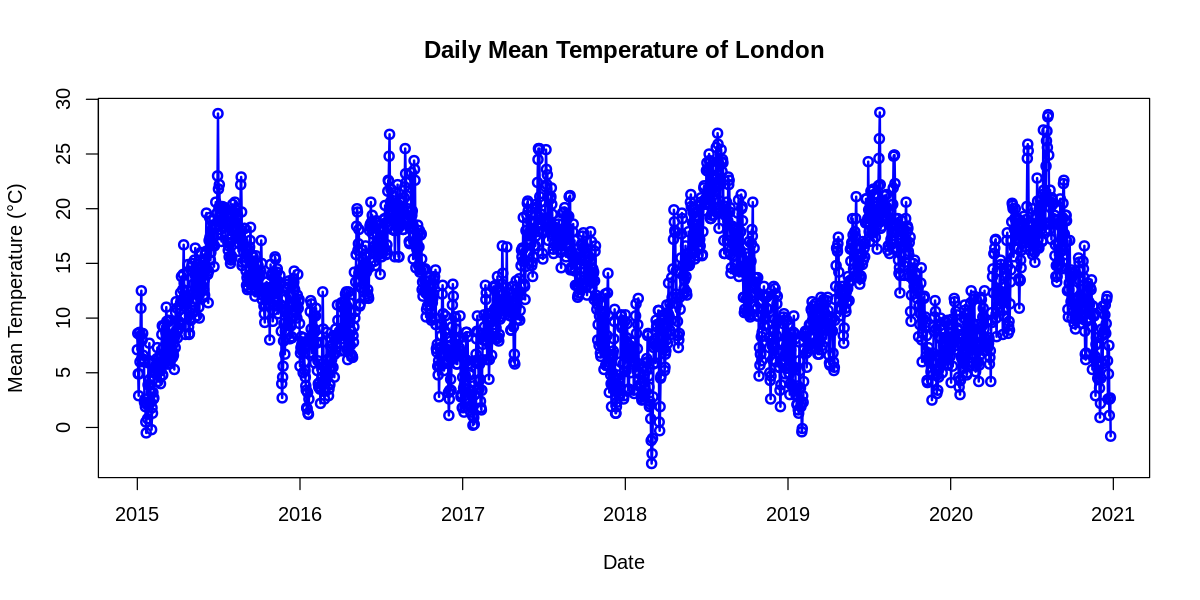

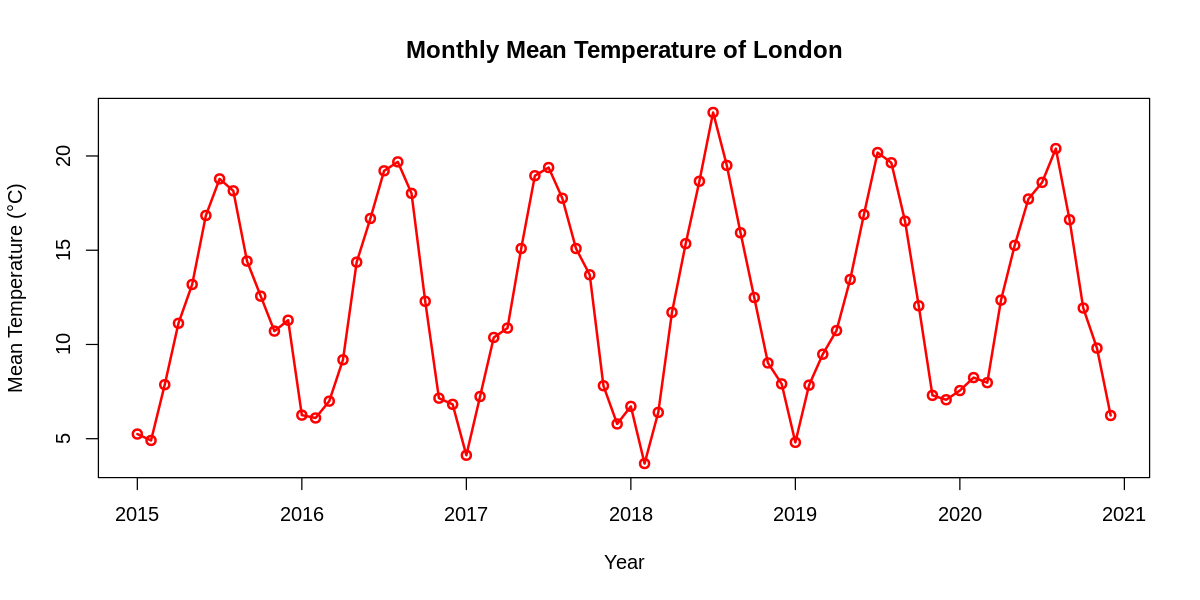

In [ ]:
# Create time series objects for both daily and monthly data
daily_mean_temp_ts <- ts(daily_data$mean_temp, frequency = 365, start = c(2015, 1))
monthly_mean_temp_ts <- ts(monthly_data$monthly_mean_temp, frequency = 12, start = c(2015, 1))

options(repr.plot.width=10, repr.plot.height=5)

# Plot daily mean temperature
plot(daily_mean_temp_ts, type = "o", main = "Daily Mean Temperature of London",
     xlab = "Date", ylab = "Mean Temperature (°C)", col = "blue", lwd = 2)

# Plot monthly mean temperature
plot(monthly_mean_temp_ts, type = "o", main = "Monthly Mean Temperature of London",
     xlab = "Year", ylab = "Mean Temperature (°C)", col = "red", lwd = 2)

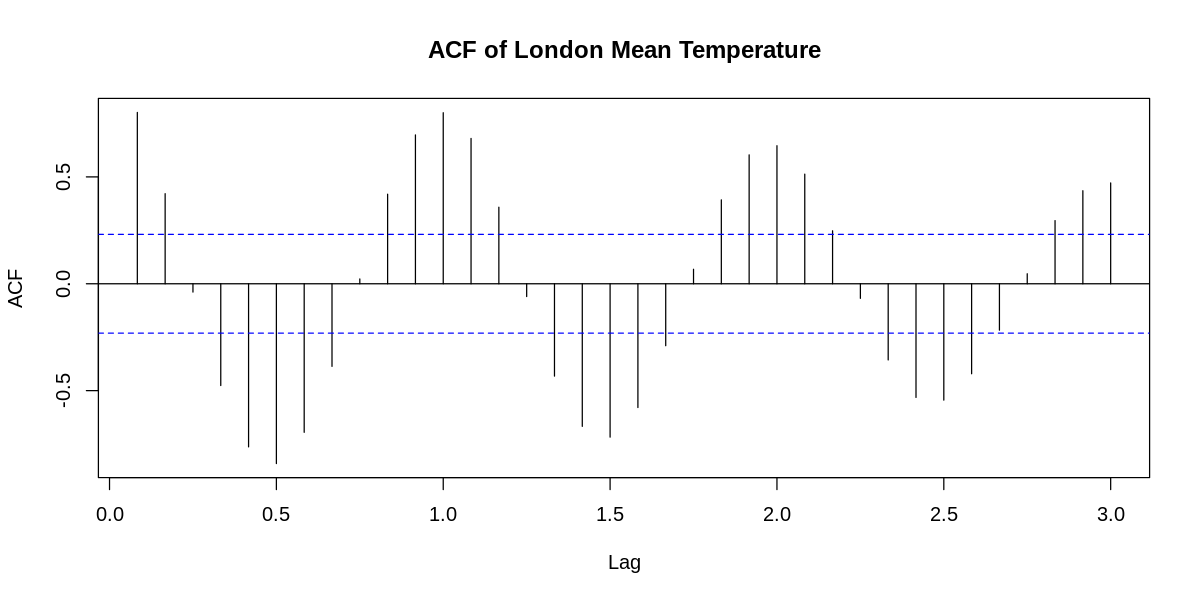

In [ ]:
# ACF Plot
acf(monthly_mean_temp_ts, lag.max = 36, main = "ACF of London Mean Temperature")

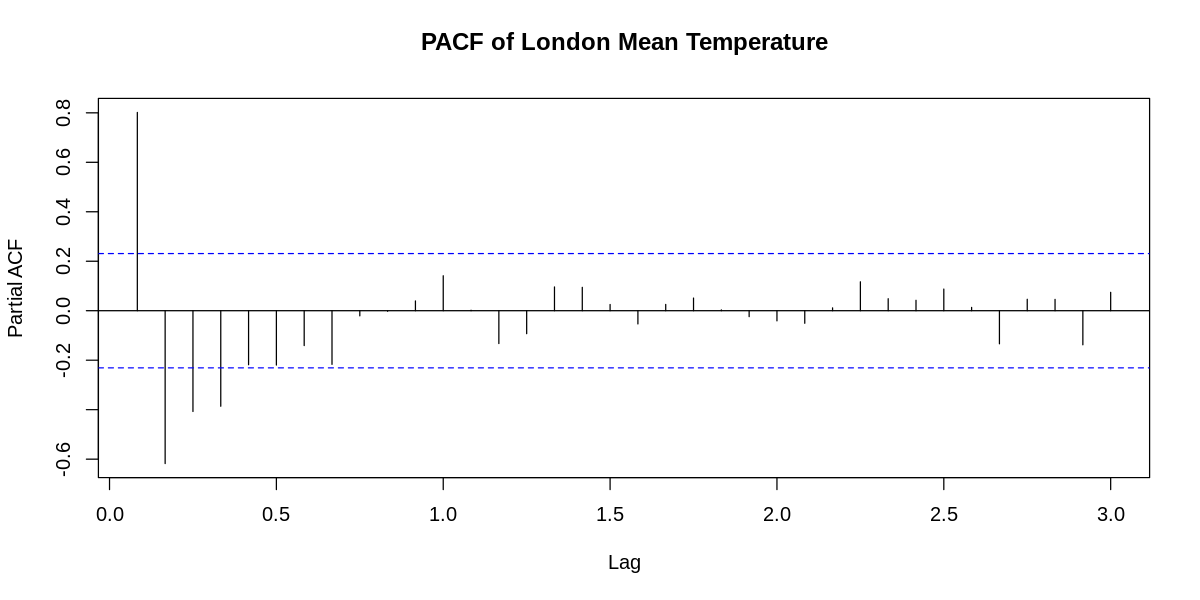

In [ ]:
# PACF Plot
pacf(monthly_mean_temp_ts, lag.max = 36, main = "PACF of London Mean Temperature")

### Applying Seasonal Differencing

Since there was no clear upward or downward trend, we did not conduct first differencing. However, there is a clear seasonal pattern in the original time series, so we decided to conduct seasonal differencing to make the time series data stationary.

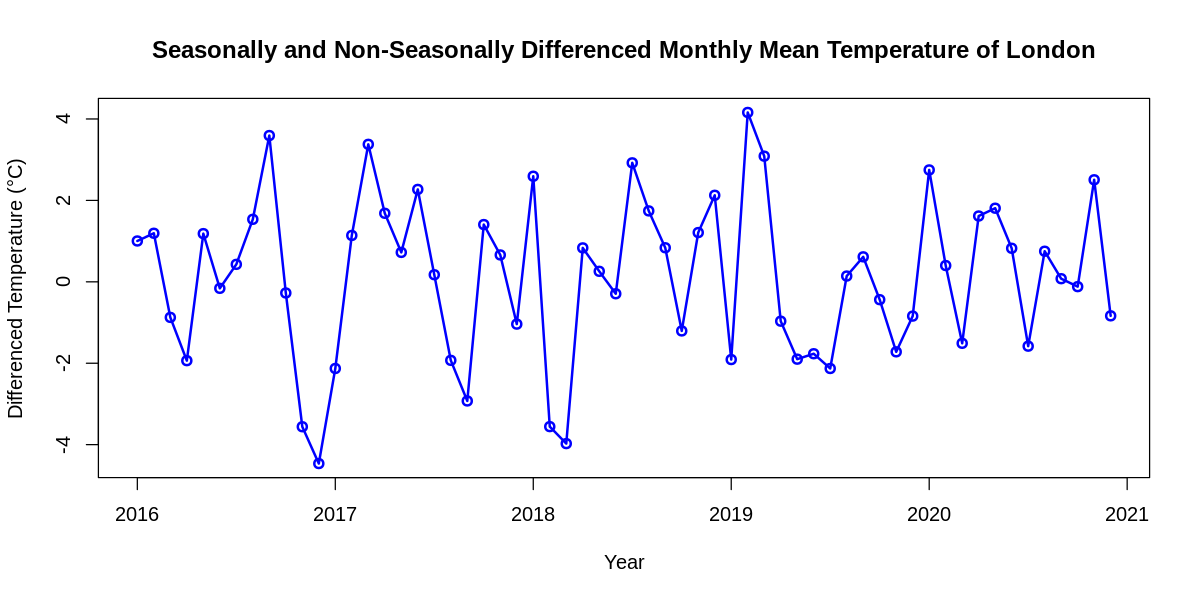

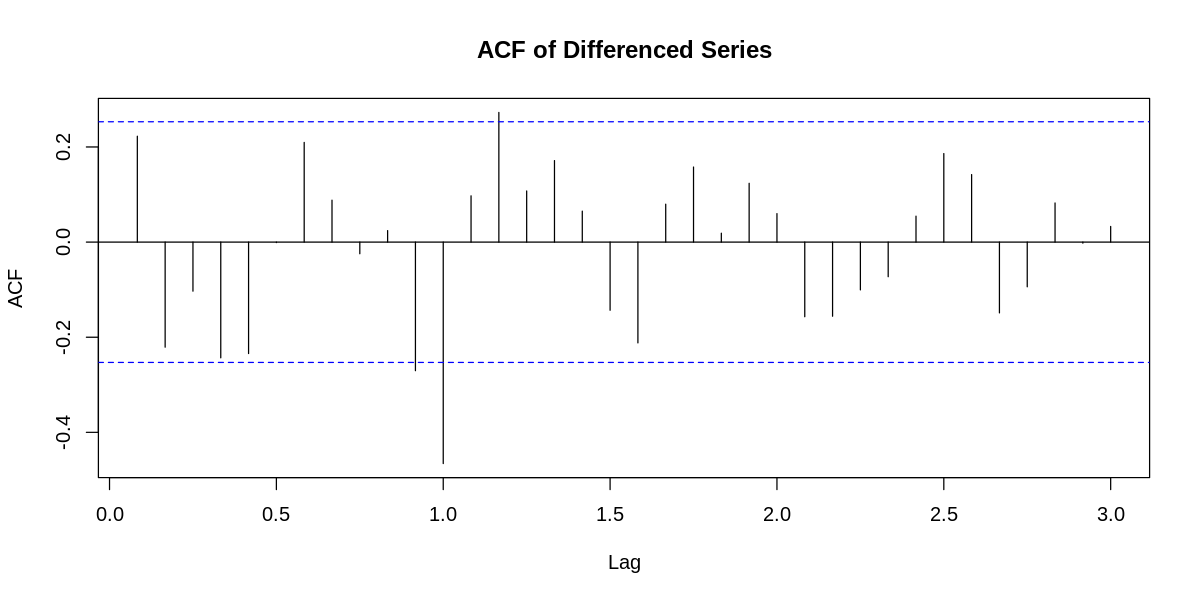

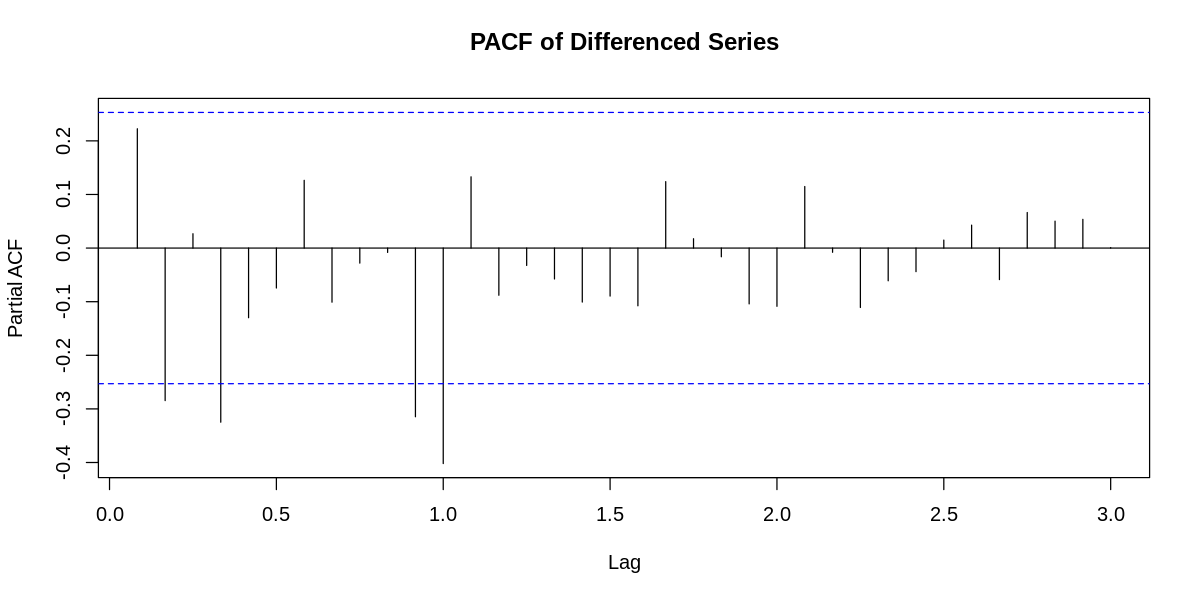

In [ ]:
# Seasonal differencing (removes seasonal pattern)
seasonal_diff_ts <- diff(monthly_mean_temp_ts, lag = 12, differences = 1)

# Plot the combined differenced series
plot(seasonal_diff_ts, type = "o",
     main = "Seasonally and Non-Seasonally Differenced Monthly Mean Temperature of London",
     xlab = "Year", ylab = "Differenced Temperature (°C)",
     col = "blue", lwd = 2)

acf(seasonal_diff_ts, lag.max = 36, main = "ACF of Differenced Series")
pacf(seasonal_diff_ts, lag.max = 36, main = "PACF of Differenced Series")

From observing the ACF and PACF of the seasonally differenced time series, we found potential SARIMA Models based on the ACF and PACF:

P = 1

D = 1

Q = 1

p = 0,1,2,4

d = 0

q = 0,1

s = 12

In [ ]:
# Perform ADF test to check stationarity
adf.test(seasonal_diff_ts)

Warning message in adf.test(seasonal_diff_ts):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  seasonal_diff_ts
Dickey-Fuller = -5.3354, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


The p-value of the ADF test is less than 0.05, signifying that the data is stationary.

In [ ]:
# Identify Potential Models with EACF
eacf_result <- eacf(seasonal_diff_ts)

AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 o o o o o o o o o o o  x  o  o 
1 x x o o o o o o o o o  x  o  o 
2 o x o o o o o o o o o  x  o  x 
3 o x o o o o o o o o o  x  o  x 
4 x o o o o o o o o o o  x  o  o 
5 x o o x o o o o o o o  x  o  o 
6 x o o o o o o o o o o  x  o  o 
7 x o x o o o o o o o o  x  o  o 


### Testing SARIMA Models

Using the potential P,D,Q,p,d,q values found from above using the ACF, PACF, and EACF, we conducted several combinations of these parameters to find the best and most effective model by looking at the AIC, BIC, and log likelihood scores.

In [ ]:
model1 <- Arima(monthly_mean_temp_ts, order = c(0,0,0), seasonal = list(order = c(1,1,1), period = 12))
summary(model1)

Series: monthly_mean_temp_ts 
ARIMA(0,0,0)(1,1,1)[12] 

Coefficients:
         sar1     sma1
      -0.2478  -0.7982
s.e.   0.1778   0.4039

sigma^2 = 1.918:  log likelihood = -111.79
AIC=229.58   AICc=230.01   BIC=235.86

Training set error measures:
                    ME    RMSE       MAE        MPE     MAPE      MASE
Training set 0.1755313 1.24312 0.9394496 -0.6404755 10.13201 0.5891824
                  ACF1
Training set 0.2675791

In [ ]:
model2 <- Arima(monthly_mean_temp_ts, order = c(0,0,1), seasonal = list(order = c(1,1,1), period = 12))
summary(model2)

Series: monthly_mean_temp_ts 
ARIMA(0,0,1)(1,1,1)[12] 

Coefficients:
         ma1     sar1     sma1
      0.4353  -0.2471  -0.8387
s.e.  0.1525   0.1769   0.5162

sigma^2 = 1.665:  log likelihood = -108.03
AIC=224.06   AICc=224.79   BIC=232.44

Training set error measures:
                    ME     RMSE       MAE        MPE     MAPE      MASE
Training set 0.1094818 1.148218 0.8512624 -0.8067559 9.308329 0.5338752
                    ACF1
Training set -0.04917032

In [ ]:
model3 <- Arima(monthly_mean_temp_ts, order = c(0,0,1), seasonal = list(order = c(0,1,0), period = 12))
summary(model3)

Series: monthly_mean_temp_ts 
ARIMA(0,0,1)(0,1,0)[12] 

Coefficients:
         ma1
      0.4812
s.e.  0.1665

sigma^2 = 3.432:  log likelihood = -121.75
AIC=247.51   AICc=247.72   BIC=251.7

Training set error measures:
                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set 0.06359109 1.676892 1.249359 -1.669809 13.87351 0.7835441
                   ACF1
Training set -0.1110112

In [ ]:
model4 <- Arima(monthly_mean_temp_ts, order = c(1,0,0), seasonal = list(order = c(1,1,1), period = 12))
summary(model4)

Series: monthly_mean_temp_ts 
ARIMA(1,0,0)(1,1,1)[12] 

Coefficients:
         ar1     sar1     sma1
      0.2955  -0.2639  -0.9620
s.e.  0.1247   0.1685   2.1884

sigma^2 = 1.544:  log likelihood = -109.12
AIC=226.23   AICc=226.96   BIC=234.61

Training set error measures:
                    ME     RMSE       MAE        MPE    MAPE      MASE
Training set 0.1130054 1.105562 0.8356696 -0.6522771 9.04963 0.5240961
                   ACF1
Training set 0.04974102

In [ ]:
model5 <- Arima(monthly_mean_temp_ts, order = c(1,0,1), seasonal = list(order = c(1,1,1), period = 12))
summary(model5)

Series: monthly_mean_temp_ts 
ARIMA(1,0,1)(1,1,1)[12] 

Coefficients:
          ar1     ma1     sar1     sma1
      -0.3876  0.7748  -0.2184  -0.8439
s.e.   0.2531  0.1877   0.1868   0.5195

sigma^2 = 1.652:  log likelihood = -107.2
AIC=224.39   AICc=225.51   BIC=234.87

Training set error measures:
                    ME     RMSE       MAE        MPE     MAPE      MASE
Training set 0.1285371 1.133657 0.8404937 -0.6766559 9.044341 0.5271215
                    ACF1
Training set 0.003224032

In [ ]:
model6 <- Arima(monthly_mean_temp_ts, order = c(2,0,0), seasonal = list(order = c(1,1,1), period = 12))
summary(model6)

Series: monthly_mean_temp_ts 
ARIMA(2,0,0)(1,1,1)[12] 

Coefficients:
         ar1      ar2     sar1     sma1
      0.3424  -0.1733  -0.2320  -0.8081
s.e.  0.1289   0.1345   0.1812   0.4362

sigma^2 = 1.762:  log likelihood = -108.31
AIC=226.62   AICc=227.73   BIC=237.09

Training set error measures:
                    ME     RMSE       MAE        MPE     MAPE     MASE
Training set 0.1340716 1.170759 0.8606553 -0.8302738 9.542778 0.539766
                    ACF1
Training set 0.008407831

In [ ]:
model7 <- Arima(monthly_mean_temp_ts, order = c(2,0,1), seasonal = list(order = c(1,1,1), period = 12))
summary(model7)

Series: monthly_mean_temp_ts 
ARIMA(2,0,1)(1,1,1)[12] 

Coefficients:
         ar1      ar2      ma1     sar1     sma1
      1.0842  -0.3744  -0.7996  -0.2290  -0.7202
s.e.  0.1770   0.1239   0.1520   0.1856   0.3270

sigma^2 = 1.853:  log likelihood = -107.63
AIC=227.27   AICc=228.85   BIC=239.83

Training set error measures:
                    ME     RMSE       MAE        MPE     MAPE      MASE
Training set 0.2051882 1.189628 0.8764956 -0.2096886 9.675425 0.5497004
                    ACF1
Training set -0.01347255

In [ ]:
model8 <- Arima(monthly_mean_temp_ts, order = c(4,0,0), seasonal = list(order = c(1,1,1), period = 12))
summary(model8)

Series: monthly_mean_temp_ts 
ARIMA(4,0,0)(1,1,1)[12] 

Coefficients:
         ar1      ar2     ar3      ar4     sar1     sma1
      0.3753  -0.2721  0.1835  -0.2866  -0.2394  -0.7448
s.e.  0.1261   0.1412  0.1399   0.1271   0.1866   0.3132

sigma^2 = 1.74:  log likelihood = -105.79
AIC=225.59   AICc=227.74   BIC=240.25

Training set error measures:
                   ME     RMSE       MAE        MPE     MAPE      MASE
Training set 0.159636 1.142284 0.8463743 -0.4730022 9.131802 0.5308096
                    ACF1
Training set -0.03688183

Model 2, with AIC=224.06 and BIC=232.44, is the best model due to its lowest AIC and BIC scores, and is the model we analyze the residuals of.

### Residual Analysis

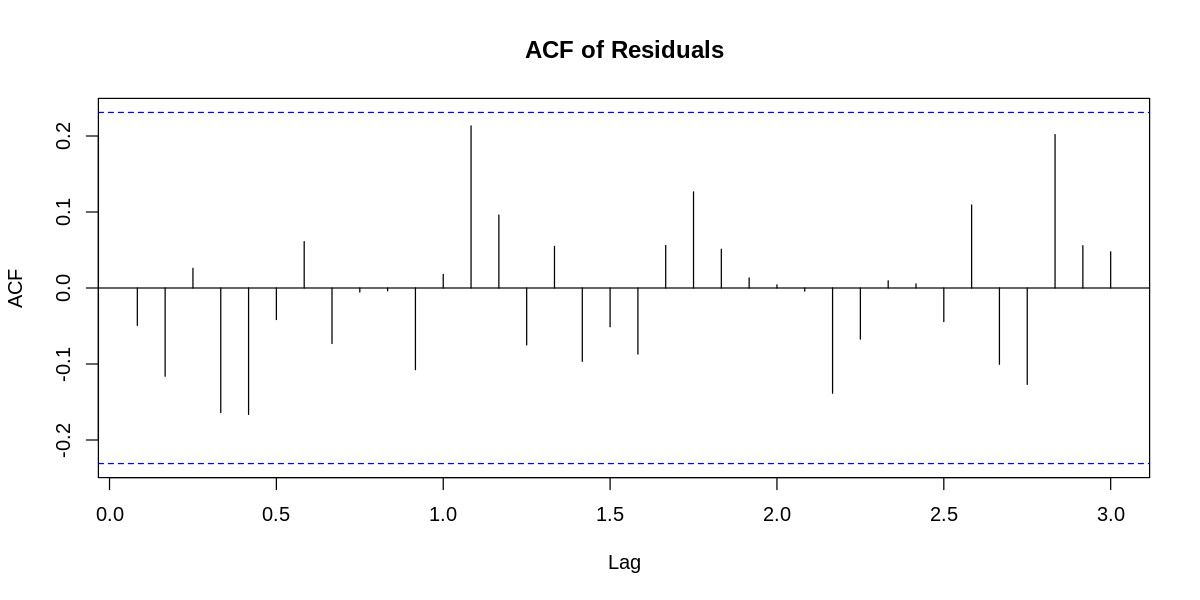

In [ ]:
residuals <- residuals(model2)
acf(residuals, lag.max = 36, main = "ACF of Residuals")

Since the residuals are white noise, this suggests that the model has effectively captured the underlying structure of the data and that no further information is left unexplained by the model.

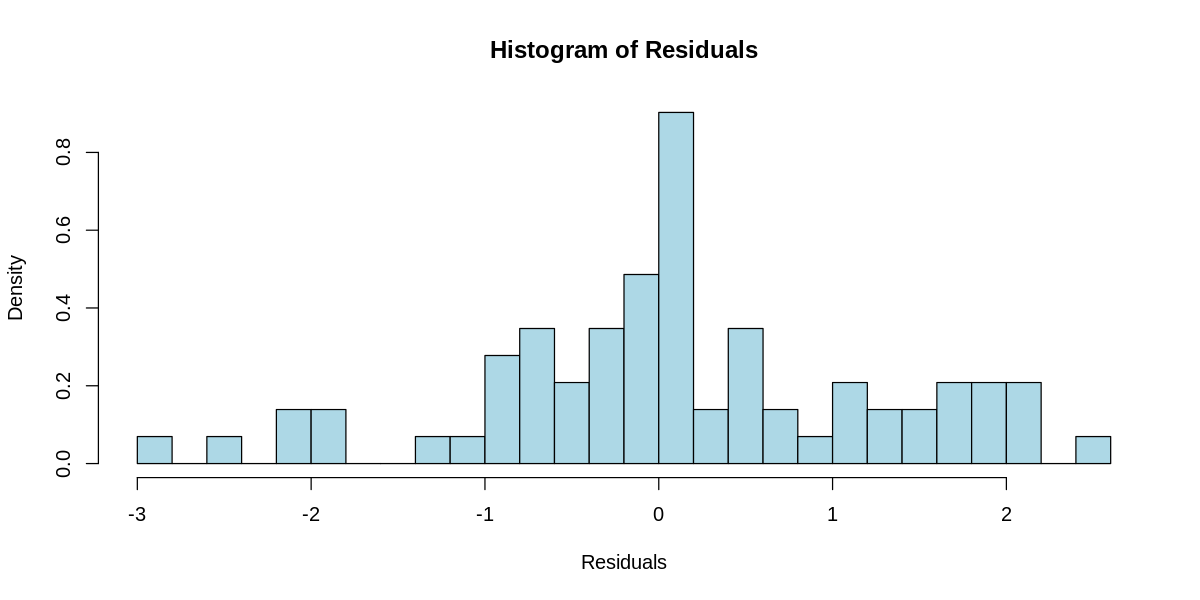

In [ ]:
# Plot the histogram of residuals
hist(residuals, main = "Histogram of Residuals",
     xlab = "Residuals", col = "lightblue", breaks = 20,
     probability = TRUE)

The histogram of the residuals shows that the residuals follow a normal distribution. The symmetry and bell-shaped curve indicate that the residuals are approximately normally distributed, which is a good sign. This suggests that the model has appropriately captured the underlying patterns in the data, and the assumptions of normality are satisfied, supporting the validity of the model.

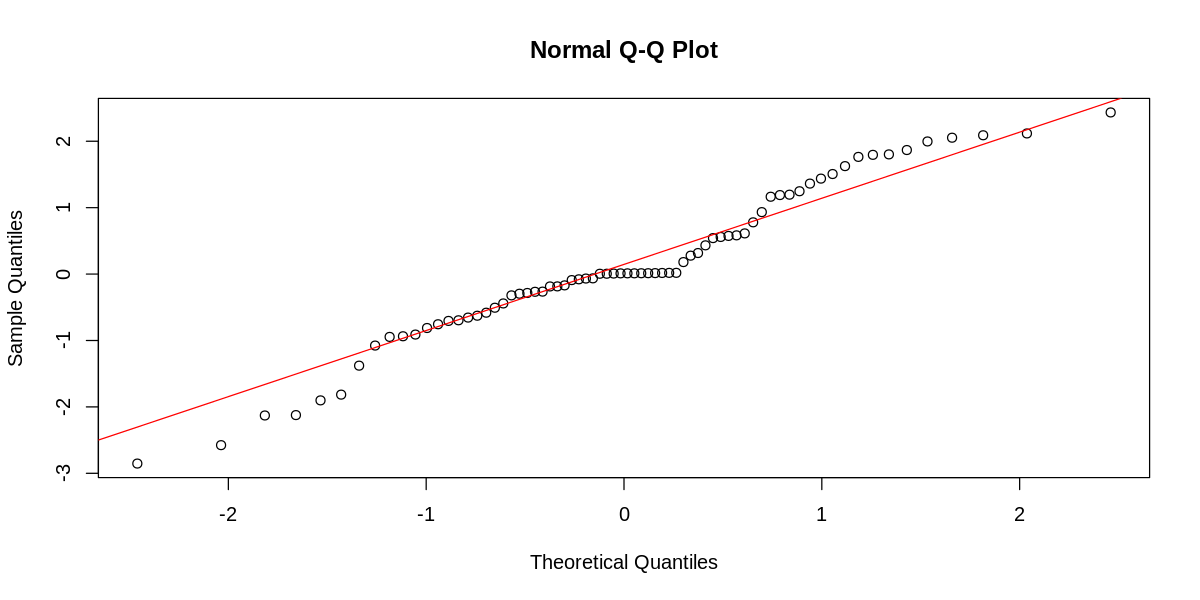

In [ ]:
qqnorm(residuals)
qqline(residuals, col = "red")

The Q-Q (quantile-quantile) plot of the residuals shows that the points closely follow a straight line, indicating that the residuals are approximately normally distributed. This suggests that the assumption of normality holds for the residuals, as there are no major deviations from the expected distribution. Overall, the Q-Q plot further supports the validity of the model by confirming that the residuals exhibit the desired characteristics of normality.

In [ ]:
shapiro.test(residuals)


	Shapiro-Wilk normality test

data:  residuals
W = 0.96795, p-value = 0.063


The Shapiro-Wilk normality test for the residuals yielded a W statistic of 0.96795 with a p-value of 0.063. Since the p-value is greater than the typical significance level of 0.05, we fail to reject the null hypothesis that the residuals follow a normal distribution. This suggests that the residuals are approximately normally distributed, further supporting the validity of the model.

In [ ]:
Box.test(residuals, lag = 12, type = "Ljung-Box")


	Box-Ljung test

data:  residuals
X-squared = 7.4939, df = 12, p-value = 0.8233


The Ljung-Box test for autocorrelation in the residuals produced an X-squared statistic of 7.4939 with 12 degrees of freedom and a p-value of 0.8233. Since the p-value is much greater than the typical significance level of 0.05, we fail to reject the null hypothesis that there is no autocorrelation in the residuals. This suggests that the residuals are uncorrelated, indicating that the model has adequately captured the underlying patterns in the data.

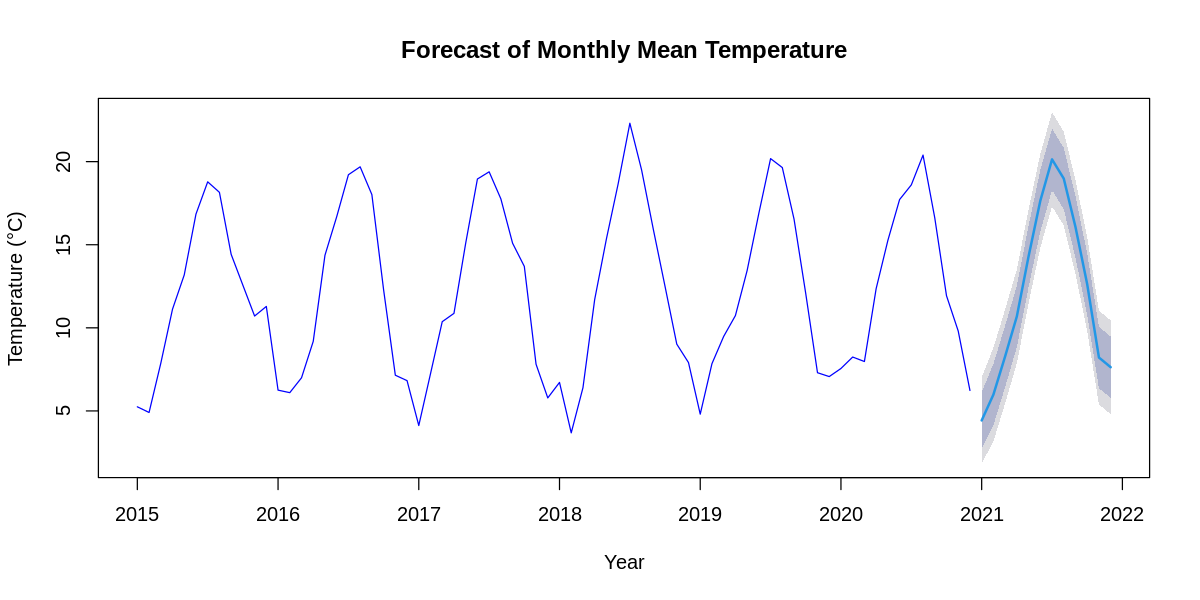

In [ ]:
# Forecast next 12 months
forecast_horizon <- 12
future_forecast <- forecast(model2, h = forecast_horizon)

plot(future_forecast,
     main = "Forecast of Monthly Mean Temperature",
     xlab = "Year", ylab = "Temperature (°C)",
     col = "blue", flwd = 2)

### Model Application to Full Dataset

Now that we are satisfied with the residuals of our model and how well it fits our time series, we apply this model to fit the original, nontruncated series to assess its fit below.

In [ ]:
df_cleaned <- df %>%
  filter(!is.na(mean_temp))
df_cleaned$month <- format(df_cleaned$date, "%Y-%m")
monthly_data <- df_cleaned %>%
  group_by(month) %>%
  summarise(monthly_mean_temp = mean(mean_temp, na.rm = TRUE))
monthly_data$date <- as.Date(paste0(monthly_data$month, "-01"))

long_monthly_mean_temp_ts <- ts(monthly_data$monthly_mean_temp, frequency = 12, start = c(1979, 1))

long_model <- Arima(long_monthly_mean_temp_ts, order = c(0,0,1), seasonal = list(order = c(1,1,1), period = 12))
summary(long_model)

Series: long_monthly_mean_temp_ts 
ARIMA(0,0,1)(1,1,1)[12] 

Coefficients:
         ma1     sar1     sma1
      0.1994  -0.0089  -0.8792
s.e.  0.0420   0.0510   0.0272

sigma^2 = 2.071:  log likelihood = -884.73
AIC=1777.47   AICc=1777.55   BIC=1794.26

Training set error measures:
                    ME     RMSE      MAE       MPE     MAPE     MASE
Training set 0.2716247 1.417563 1.108411 0.8199393 16.38502 0.724178
                    ACF1
Training set -0.02044282

In [ ]:
adf.test(residuals(long_model))

Warning message in adf.test(residuals(long_model)):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  residuals(long_model)
Dickey-Fuller = -6.959, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


While the AIC, BIC, and log likelihood values are all worse, the Augmented-Dickey-Fuller Test still indicates that the residual series is stationary.

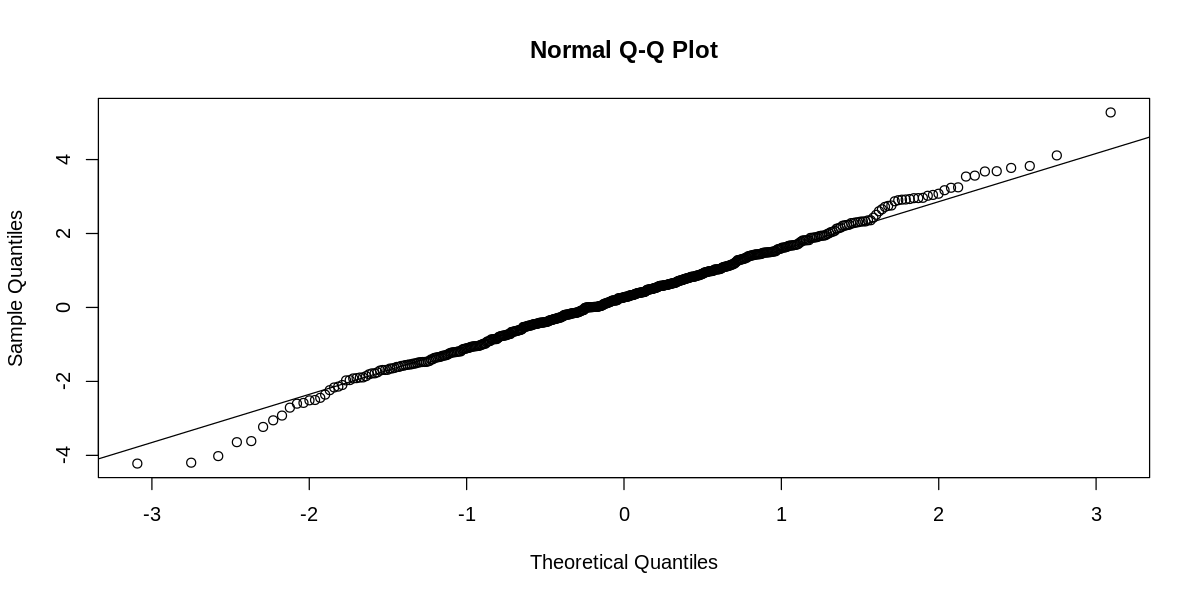

In [ ]:
qqnorm(residuals(long_model))
qqline(residuals(long_model))


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1)(1,1,1)[12]
Q* = 26.627, df = 21, p-value = 0.1836

Model df: 3.   Total lags used: 24



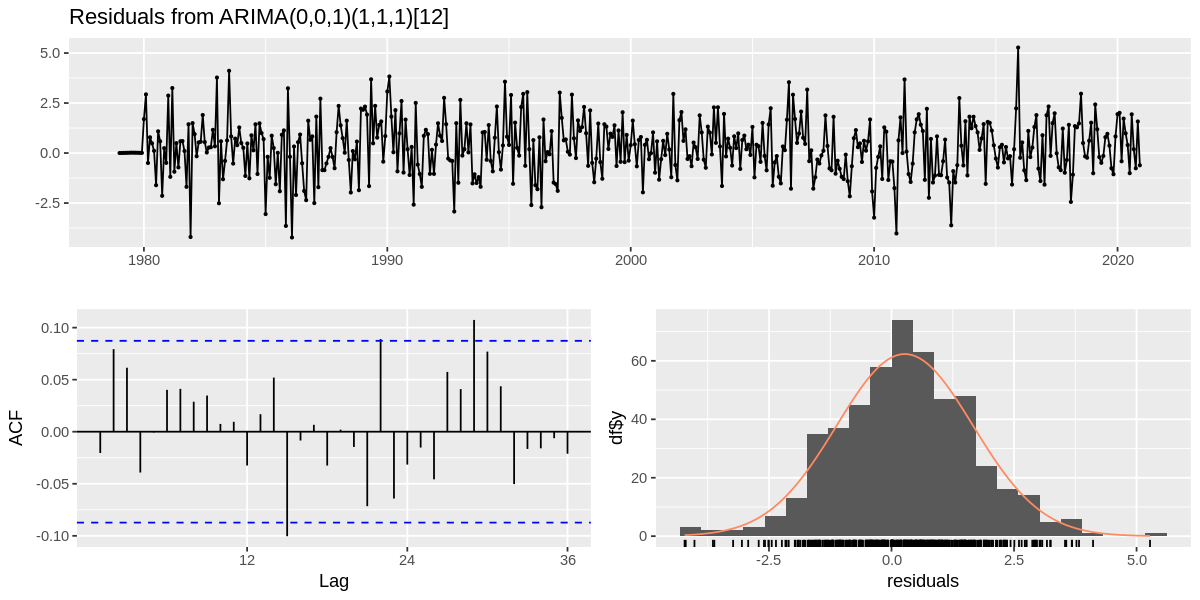

In [ ]:
checkresiduals(long_model)

The Ljung-Box test provided a p-value of 0.1836. Because this is greater than 0.05, we can conclude that the residuals are uncorrelated, indicating that the model has adequately captured the underlying patterns in the data.

In [ ]:
shapiro.test(residuals(long_model))


	Shapiro-Wilk normality test

data:  residuals(long_model)
W = 0.99609, p-value = 0.249


The Shapiro-Wilk test provided a p-value of 0.249, which is above the 0.05 threshold, and we once again fail to reject the null hypothesis that the residuals follow a normal distribution, which is corroborated by the plotted histogram. The ACF plot still largely resembles white noise, indicating that the model is still a valid fit for the full dataset.

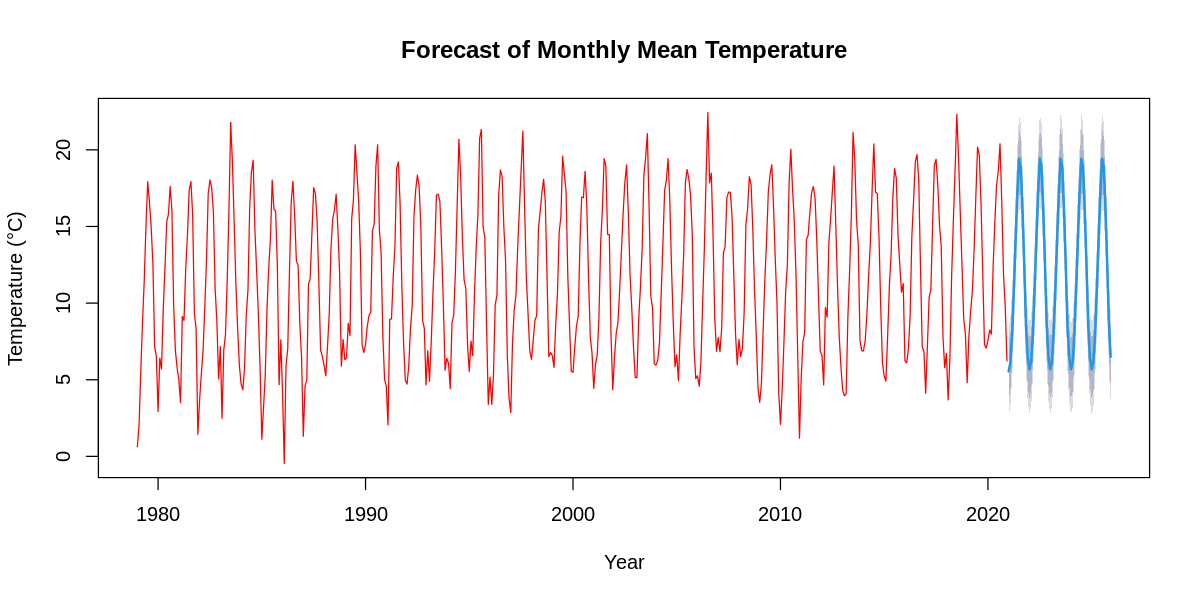

In [ ]:
long_future_forecast <- forecast(long_model, h = 60)

plot(long_future_forecast,
     main = "Forecast of Monthly Mean Temperature",
     xlab = "Year", ylab = "Temperature (°C)",
     col = "red", flwd = 2)

Using this ARIMA(0,0,1)(1,1,1)<sub>12</sub> model, we are still able to reasonably forecast the temperature five years into the future.

### Final Thoughts

Based on the residual analysis for both the truncated dataset and the full dataset, we are confident in the validity of this model. In both cases the residuals are stationary, as shown by the Augmented Dickey-Fuller test, and they are normally distributed, as shown by the Shapiro-Wilk test. Additionally, the ACF plot for the residuals resembles white noise, as shown by the Ljung-Box test, indicating they are largely uncorrelated. We decided not to pursue a GARCH model with this data as there does not seem fo be any significant volatility, and we have reasonably fit the data without it.

Furthermore, the short term forecast of one year for the truncated data along with the long term forecast of five years for the full dataset seem to show reasonable predictions based on past trends and seasonality.